# Phase 3 - Modeling

**Note 1: the following starting code only generates a single random train/test split when default_seed is used. You need to modify the code to generate 100 independent train/test splits with different seeds and report the average results on those independent splits along with standard deviation.**

**Note 2: You are completely free to use your own implementation.**

In [1]:
# Load general utilities
# ----------------------
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import datetime
import numpy as np
import pickle
import time
import seaborn as sns

# Load sklearn utilities
# ----------------------
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, classification_report, roc_auc_score, roc_curve, brier_score_loss, mean_squared_error, r2_score
from sklearn.calibration import calibration_curve

# Load classifiers
# ----------------
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier

# Other Packages
# --------------
from scipy.stats import kendalltau
from sklearn.neural_network import MLPRegressor
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from six import StringIO 
from IPython.display import Image  
from sklearn.tree import export_graphviz
from imblearn.over_sampling import SMOTE
# from scipy.interpolate import spline

# Load debugger, if required
#import pixiedust
pd.options.mode.chained_assignment = None #'warn'

# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Define a function that, given a CVGridSearch object, finds the
# percentage difference between the best and worst scores
def find_score_variation(cv_model):
    all_scores = cv_model.cv_results_['mean_test_score']
    return( np.abs((max(all_scores) - min(all_scores))) * 100 / max(all_scores) )

    '''
    which_min_score = np.argmin(all_scores)
    
    all_perc_diff = []
    
    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score - 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass
    
    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score + 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass
    
    return ( np.mean(all_perc_diff) )
    '''

# Define a function that checks, given a CVGridSearch object,
# whether the optimal parameters lie on the edge of the search
# grid
def find_opt_params_on_edge(cv_model):
    out = False
    
    for i in cv_model.param_grid:
        if cv_model.best_params_[i] in [ cv_model.param_grid[i][0], cv_model.param_grid[i][-1] ]:
            out = True
            break
            
    return out

## Define a default random seed and an output file

In [3]:
default_seed = 1
output_file = "output_sample"

In [4]:
# Create a function to print a line to our output file
def dump_to_output(key, value):
    with open(output_file, "a") as f:
        f.write(",".join([str(default_seed), key, str(value)]) + "\n")

## Load the data and engineer the features

In [5]:
# Read the data and features from the pickle file saved in CS-Phase 2
data, discrete_features, continuous_features, ret_cols = pickle.load( open( "clean_data.pickle", "rb" ) )

In [6]:
## Create the outcome columns: True if loan_status is either Charged Off or Default, False otherwise
data["outcome"] = ((data['loan_status'] == 'Charged Off') | (data['loan_status'] == 'Default'))

In [7]:
# Create a feature for the length of a person's credit history at the time the loan is issued
data['cr_hist'] = (data.issue_d - data.earliest_cr_line) / np.timedelta64(1, 'M')
continuous_features.append('cr_hist')

In [8]:
# Copy the data to save current state
data_copy = data.copy()

# Randomly assign each row to a training and test set. We do this now because we will be fitting a variety of models on various time periods, and we would like every period to use the *same* training/test split
np.random.seed(default_seed)
## create the train columns where the value is True if it is a train instance and False otherwise. Hint: use np.random.choice with 70% for training and 30% for testing
indices = np.random.choice(range(len(data)), int(0.7*len(data)), replace=False)

data['train'] = False
data['train'].iloc[list(indices)] = True

# the 'data' variable now refers to the split using the default_seed = 1

In [9]:
# Create a matrix of features and outcomes, with dummies. Record the names of the dummies for later use
X_continuous = data[continuous_features].to_numpy()

X_discrete = pd.get_dummies(data[discrete_features], dummy_na = True, prefix_sep = "::", drop_first = True)
discrete_features_dummies = X_discrete.columns.tolist()
X_discrete = X_discrete.values

X = np.concatenate( (X_continuous, X_discrete), axis = 1 )
y = data.outcome.to_numpy()

train = data.train.to_numpy()

# Part 1 

## Prepare functions to fit and evaluate models

In [10]:
def prepare_data(data_subset = np.array([True]*len(data)),
                    n_samples_train = 30000,
                    n_samples_test = 20000,
                    feature_subset = None,
                    date_range_train = (data.issue_d.min(), data.issue_d.max()),
                    date_range_test = (data.issue_d.min(), data.issue_d.max()),
                    random_state = default_seed):
    '''
    This function will prepare the data for classification or regression.
    It expects the following parameters:
      - data_subset: a numpy array with as many entries as rows in the
                     dataset. Each entry should be True if that row
                     should be used, or False if it should be ignored
      - n_samples_train: the total number of samples to be used for training.
                         Will trigger an error if this number is larger than
                         the number of rows available after all filters have
                         been applied
      - n_samples_test: as above for testing
      - feature_subect: A list containing the names of the features to be
                        used in the model. In None, all features in X are
                        used
      - date_range_train: a tuple containing two dates. All rows with loans
                          issued outside of these two dates will be ignored in
                          training
      - date_range_test: as above for testing
      - random_state: the random seed to use when selecting a subset of rows
      
    Note that this function assumes the data has a "Train" column, and will
    select all training rows from the rows with "True" in that column, and all
    the testing rows from those with a "False" in that column.
    
    This function returns a dictionary with the following entries
      - X_train: the matrix of training data
      - y_train: the array of training labels
      - train_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the train set
      - X_test: the matrix of testing data
      - y_test: the array of testing labels
      - test_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the test set
    '''
    
    np.random.seed(random_state)
        
    # Filter down the data to the required date range, and downsample
    # as required
    filter_train = ( train & (data.issue_d >= date_range_train[0]) &
                            (data.issue_d <= date_range_train[1]) & data_subset ).values
    filter_test = ( (train == False) & (data.issue_d >= date_range_test[0])
                            & (data.issue_d <= date_range_test[1]) & data_subset ).values
    
    filter_train[ np.random.choice( np.where(filter_train)[0], size = filter_train.sum()
                                                   - n_samples_train, replace = False ) ] = False
    filter_test[ np.random.choice( np.where(filter_test)[0], size = filter_test.sum()
                                                   - n_samples_test, replace = False ) ] = False
    
    test_grades = data['grade'][filter_test].values
    test_data = data[filter_test].values
    
    # Prepare the training and test set
    X_train = X[ filter_train , :]
    X_test = X[ filter_test, :]
    if feature_subset != None:
        cols = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in feature_subset]
        X_train = X_train[ : , cols ]
        X_test = X_test[ : , cols ]
        
    y_train = y[ filter_train ]
    y_test = y[ filter_test ]
    
    # Scale the variables
    scaler = preprocessing.MinMaxScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # return training and testing data
    out = {'X_train':X_train, 'y_train':y_train, 'train_set':filter_train, 
           'X_test':X_test, 'y_test':y_test, 'test_set':filter_test
           , 'test_grades': test_grades,'test_data' : test_data
          }
    
    return out

## Prepare functions to create 100 independent test/train splits

#### Code for Saving 100 Independent Test/Train Splits

In [11]:
def prepare_data_for_n_test_train_splits(data,
                    discrete_features_dummies,
                    X,
                    y,
                    train,
                    n_samples_train = 30000,
                    n_samples_test = 20000,
                    feature_subset = None,
                    random_state = default_seed):

    data_subset = np.array([True]*len(data))
    
    date_range_train = (data.issue_d.min(), data.issue_d.max())
    date_range_test = (data.issue_d.min(), data.issue_d.max())
    
    np.random.seed(random_state)
        
    # Filter down the data to the required date range, and downsample
    # as required
    filter_train = ( train & (data.issue_d >= date_range_train[0]) &
                            (data.issue_d <= date_range_train[1]) & data_subset ).values
    filter_test = ( (train == False) & (data.issue_d >= date_range_test[0])
                            & (data.issue_d <= date_range_test[1]) & data_subset ).values
    
    filter_train[ np.random.choice( np.where(filter_train)[0], size = filter_train.sum()
                                                   - n_samples_train, replace = False ) ] = False
    filter_test[ np.random.choice( np.where(filter_test)[0], size = filter_test.sum()
                                                   - n_samples_test, replace = False ) ] = False
    
    # Prepare the training and test set
    X_train = X[ filter_train , :]
    X_test = X[ filter_test, :]
    if feature_subset != None:
        cols = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in feature_subset]
        X_train = X_train[ : , cols ]
        X_test = X_test[ : , cols ]
        
    y_train = y[ filter_train ]
    y_test = y[ filter_test ]
    
    # Scale the variables
    scaler = preprocessing.MinMaxScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # return training and testing data
    out = {'X_train':X_train, 'y_train':y_train, 'train_set':filter_train, 
           'X_test':X_test, 'y_test':y_test, 'test_set':filter_test}
    
    return out

In [12]:
# input copy of original data -> 'data_copy' (before default_seed random split)
def n_train_test_splits(data, num_seeds, feature_subset): 
    out = []
    seeds = [np.random.randint(1,10000) for i in range (0, num_seeds)]
    
    for seed in seeds:
        np.random.seed(seed)
        
        # Store a copy of the input data
        data_copy = data.copy()
        
        indices = np.random.choice(range(len(data_copy)), int(0.7*len(data_copy)), replace=False)

        data_copy['train'] = False
        data_copy['train'].iloc[list(indices)] = True
                
        # Create a matrix of features and outcomes, with dummies. Record the names of the dummies for later use
        X_continuous = data_copy[continuous_features].to_numpy()

        X_discrete = pd.get_dummies(data_copy[discrete_features], dummy_na = True, prefix_sep = "::", drop_first = True)
        discrete_features_dummies = X_discrete.columns.tolist() 
        X_discrete = X_discrete.values

        X = np.concatenate( (X_continuous, X_discrete), axis = 1 ) 

        y = data_copy.outcome.to_numpy() #


        train = data_copy.train.to_numpy() #
        
        
        out.append(prepare_data_for_n_test_train_splits(data_copy, discrete_features_dummies, X, y, train, feature_subset=feature_subset, random_state=seed))
        
    # Returns a list of data_dicts which can be accessed by indexing
    return out
      
        

In [13]:
## define your set of features to use in different models
your_features = ['id', 'loan_amnt', 
                'funded_amnt', 'term', 'int_rate', 'grade', 'emp_length', 'home_ownership',
                'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'purpose','dti',
                'delinq_2yrs', 'earliest_cr_line', 'open_acc', 'pub_rec', 'fico_range_high',
                'fico_range_low', 'revol_bal', 'revol_util', 'total_pymnt', 'recoveries', 'last_pymnt_d']


# prepare the train, test data for training models
data_dict = prepare_data(feature_subset = your_features)

all_features = pd.Series(continuous_features + discrete_features_dummies)
idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in your_features]
selected_features = all_features[idx]
selected_features.reset_index(drop=True,inplace=True)

In [ ]:
# Don't run this cell if you have 'hundred_train_test_splits.npy'
hundred_train_test_splits = n_train_test_splits(data_copy, 100, feature_subset = your_features)
np.save('hundred_train_test_splits.npy', hundred_train_test_splits)

In [14]:
hundred_train_test_splits = np.load('hundred_train_test_splits.npy', allow_pickle='TRUE')

In [15]:
compare1 = hundred_train_test_splits[0]['X_train']
compare2 = hundred_train_test_splits[57]['X_train']

print(len(hundred_train_test_splits))

100


## 1. Train and Test different machine learning classification models

The machine learning models listed in the following are just our suggestions. You are free to try any other models that you would like to experiment with.

In [24]:
def fit_classification(model, data_dict,
                          cv_parameters = {},
                          model_name = None,
                          random_state = default_seed,
                          output_to_file = True,
                          print_to_screen = True):
    '''
    This function will fit a classification model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
    
    If the model provided does not have a predict_proba function, we will
    simply print accuracy diagnostics and return.
    
    If the model provided does have a predict_proba function, we first
    figure out the optimal threshold that maximizes the accuracy and
    print out accuracy diagnostics. We then print an ROC curve, sensitivity/
    specificity curve, and calibration curve.
    
    This function returns a dictionary with the following entries
      - model: the best fitted model
      - y_pred: predictions for the test set
      - y_pred_probs: probability predictions for the test set, if the model
                      supports them
      - y_pred_score: prediction scores for the test set, if the model does not 
                      output probabilities.
    '''
        
    np.random.seed(random_state)
    
    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    X_train = data_dict['X_train']
    y_train = data_dict['y_train']
    
    X_test = data_dict['X_test']
    y_test = data_dict['y_test']
    
    filter_train = data_dict['train_set']    
  
    # --------------------------
    #   Step 2 - Fit the model
    # --------------------------

    cv_model = GridSearchCV(model, cv_parameters)
    
    start_time = time.time()
    cv_model.fit(X_train, y_train)
    end_time = time.time()
    
    best_model = cv_model.best_estimator_
    
    if print_to_screen:

        if model_name != None:
            print("=========================================================")
            print("  Model: " + model_name)
            print("=========================================================")

        print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
        print("Optimal parameters:")
        print(cv_model.best_params_)
        print("")
    
    # -------------------------------
    #   Step 3 - Evaluate the model
    # -------------------------------
    
    # If possible, make probability predictions
    try:
        y_pred_probs = best_model.predict_proba(X_test)[:,1]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
        
        probs_predicted = True
    except:
        probs_predicted = False
    
    # Make predictions; if we were able to find probabilities, use
    # the threshold that maximizes the accuracy in the training set.
    # If not, just use the learner's predict function
    if probs_predicted:
        y_train_pred_probs = best_model.predict_proba(X_train)[:,1]
        fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_probs)
        
        true_pos_train = tpr_train*(y_train.sum())
        true_neg_train = (1 - fpr_train) *(1-y_train).sum()
        
        best_threshold_index = np.argmax(true_pos_train + true_neg_train)
        best_threshold = 1 if best_threshold_index == 0 else thresholds_train[ best_threshold_index ]
        
        if print_to_screen:
            print("Accuracy-maximizing threshold was: " + str(best_threshold))
        
        y_pred = (y_pred_probs > best_threshold)
    else:
        y_pred = best_model.predict(X_test)
    
    if print_to_screen:
        print("Recall: ", recall_score(y_test, y_pred))
        print(classification_report(y_test, y_pred, target_names =['No default', 'Default'], digits = 4))

    if print_to_screen:
        if probs_predicted:        
            plt.figure(figsize = (13, 4.5))
            plt.subplot(2, 2, 1)

            plt.title("ROC Curve (AUC = %0.2f)"% roc_auc_score(y_test, y_pred_probs))
            plt.plot(fpr, tpr, 'b')
            plt.plot([0,1],[0,1],'r--')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')

            plt.subplot(2, 2, 3)

            plt.plot(thresholds, tpr, 'b', label = 'Sensitivity')
            plt.plot(thresholds, 1 -fpr, 'r', label = 'Specificity')
            plt.legend(loc = 'lower right')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.xlabel('Threshold')

            plt.subplot(2, 2, 2)

            fp_0, mpv_0 = calibration_curve(y_test, y_pred_probs, n_bins = 10)
            plt.plot([0,1], [0,1], 'k:', label='Perfectly calibrated')
            plt.plot(mpv_0, fp_0, 's-')
            plt.ylabel('Fraction of Positives')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.legend(loc ='upper left')
            
            plt.subplot(2, 2, 4)
            plt.hist(y_pred_probs, range=(0, 1), bins=10, histtype="step", lw=2)
            plt.xlim([0,1]); plt.ylim([0,20000])
            plt.xlabel('Mean Predicted Probability')
            plt.ylabel('Count')
            
            #plt.tight_layout()
            plt.show()
        
    # Additional Score Check
    if probs_predicted:
        y_train_score = y_train_pred_probs
    else:
        y_train_score = best_model.decision_function(X_train)
        
    tau, p_value = kendalltau(y_train_score, data.grade[filter_train])
    if print_to_screen:
        print("")
        print("Similarity to LC grade ranking: ", tau)
    
    if probs_predicted:
        brier_score = brier_score_loss(y_test, y_pred_probs)
        if print_to_screen:
            print("Brier score:", brier_score)
    
    # Return the model predictions, and the
    # test set
    # -------------------------------------
    out = {'model':best_model, 'y_pred_labels':y_pred}
    
    if probs_predicted:
        out.update({'y_pred_probs':y_pred_probs})
    else:
        y_pred_score = best_model.decision_function(X_test)
        out.update({'y_pred_score':y_pred_score})
        
    # Output results to file
    # ----------------------
    if probs_predicted and output_to_file:
        # Check whether any of the CV parameters are on the edge of
        # the search space
        opt_params_on_edge = find_opt_params_on_edge(cv_model)
        dump_to_output(model_name + "::search_on_edge", opt_params_on_edge)
        if print_to_screen:
            print("Were parameters on edge? : " + str(opt_params_on_edge))
        
        # Find out how different the scores are for the different values
        # tested for by cross-validation. If they're not too different, then
        # even if the parameters are off the edge of the search grid, we should
        # be ok
        score_variation = find_score_variation(cv_model)
        dump_to_output(model_name + "::score_variation", score_variation)
        if print_to_screen:
            print("Score variations around CV search grid : " + str(score_variation))
        
        # Print out all the scores
        dump_to_output(model_name + "::all_cv_scores", str(cv_model.cv_results_['mean_test_score']))
        if print_to_screen:
            print( str(cv_model.cv_results_['mean_test_score']) )
        
        # Dump the AUC to file
        dump_to_output(model_name + "::roc_auc", roc_auc_score(y_test, y_pred_probs) )
        
    return out

### Dummy Classifier (Baseline)

  Model: Dummy Classifier
Fit time: 0.04 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 1
Recall:  0.0
              precision    recall  f1-score   support

  No default     0.8061    1.0000    0.8926     16122
     Default     0.0000    0.0000    0.0000      3878

    accuracy                         0.8061     20000
   macro avg     0.4031    0.5000    0.4463     20000
weighted avg     0.6498    0.8061    0.7196     20000



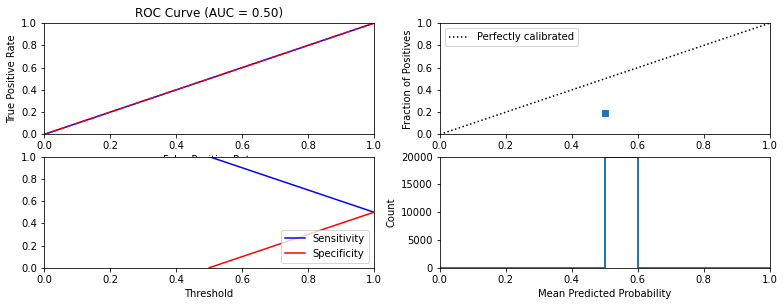


Similarity to LC grade ranking:  nan
Brier score: 0.25
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.50343333]


In [ ]:
from sklearn.dummy import DummyClassifier

dc = DummyClassifier(strategy="uniform")
dc = fit_classification(dc, 
                       data_dict,
                        model_name = 'Dummy Classifier'
                       )

### Naive Bayes

  Model: Naive Bayes
Fit time: 48.98 seconds
Optimal parameters:
{'var_smoothing': 0.657933224657568}

Accuracy-maximizing threshold was: 0.4948639508842411
Recall:  0.02475502836513667
              precision    recall  f1-score   support

  No default     0.8094    0.9961    0.8931     16122
     Default     0.6038    0.0248    0.0476      3878

    accuracy                         0.8077     20000
   macro avg     0.7066    0.5104    0.4703     20000
weighted avg     0.7695    0.8077    0.7291     20000



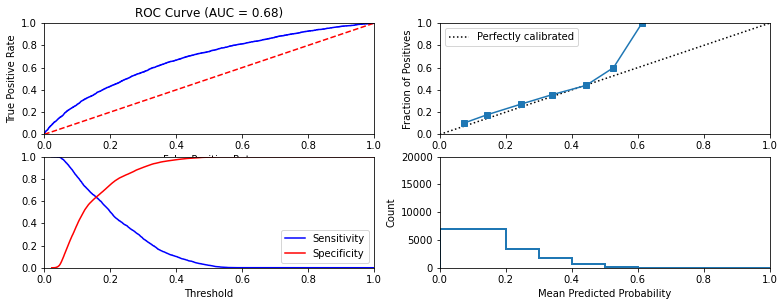


Similarity to LC grade ranking:  0.6473810778695849
Brier score: 0.14647599696913433
Were parameters on edge? : False
Score variations around CV search grid : 68.21715041759695
[0.80546667 0.80563333 0.8062     0.8049     0.8019     0.79373333
 0.78793333 0.78186667 0.77736667 0.77293333 0.76993333 0.76663333
 0.76363333 0.76083333 0.75916667 0.75743333 0.75566667 0.75496667
 0.75436667 0.7543     0.75323333 0.75306667 0.75253333 0.75216667
 0.75156667 0.75136667 0.75106667 0.75013333 0.74913333 0.7478
 0.74663333 0.7447     0.74363333 0.7428     0.74153333 0.73956667
 0.73703333 0.735      0.7326     0.73003333 0.72663333 0.7232
 0.71896667 0.71483333 0.70953333 0.70386667 0.6981     0.69106667
 0.6831     0.6743     0.66573333 0.65613333 0.6472     0.63676667
 0.62486667 0.6142     0.60186667 0.58903333 0.57276667 0.55683333
 0.53906667 0.52333333 0.50673333 0.4896     0.47286667 0.4585
 0.44483333 0.43213333 0.4201     0.40966667 0.40013333 0.3908
 0.3823     0.3747     0.3666     

In [ ]:
## Train and test a naive bayes classifier
gnb = GaussianNB()
gnb = fit_classification(gnb, 
                         data_dict, 
                         cv_parameters = {'var_smoothing': np.logspace(0,-9, num=100)}
                         ,model_name="Naive Bayes")

### $l_1$ regularized logistic regression

  Model: l1 Regularized Logistic Regression
Fit time: 250.45 seconds
Optimal parameters:
{'C': 0.1}

Accuracy-maximizing threshold was: 0.4831841297177727
Recall:  0.04667354306343476
              precision    recall  f1-score   support

  No default     0.8122    0.9918    0.8931     16122
     Default     0.5783    0.0467    0.0864      3878

    accuracy                         0.8085     20000
   macro avg     0.6952    0.5192    0.4897     20000
weighted avg     0.7669    0.8085    0.7367     20000



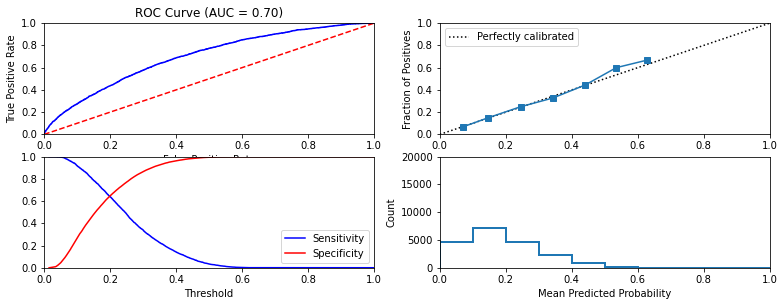


Similarity to LC grade ranking:  0.6930825094927892
Brier score: 0.14374543467470272
Were parameters on edge? : False
Score variations around CV search grid : 0.30941870539214383
[0.80546667 0.80796667 0.80783333 0.80783333 0.80783333 0.80783333]


In [ ]:
## Train and test a l_1 regularized logistic regression classifier
l1_logistic = LogisticRegression(penalty='l1', solver='liblinear')
cv_parameters = {'C':[0.01, 0.1, 1, 10, 100, 1000]}

l1_logistic = fit_classification(l1_logistic, data_dict, cv_parameters, model_name='l1 Regularized Logistic Regression')

### $l_2$ regularized logistic regression

  Model: l2 Regularized Logistic Regression
Fit time: 16.92 seconds
Optimal parameters:
{'C': 0.1}

Accuracy-maximizing threshold was: 0.5032773436394316
Recall:  0.03558535327488396
              precision    recall  f1-score   support

  No default     0.8108    0.9944    0.8933     16122
     Default     0.6026    0.0356    0.0672      3878

    accuracy                         0.8085     20000
   macro avg     0.7067    0.5150    0.4802     20000
weighted avg     0.7705    0.8085    0.7331     20000



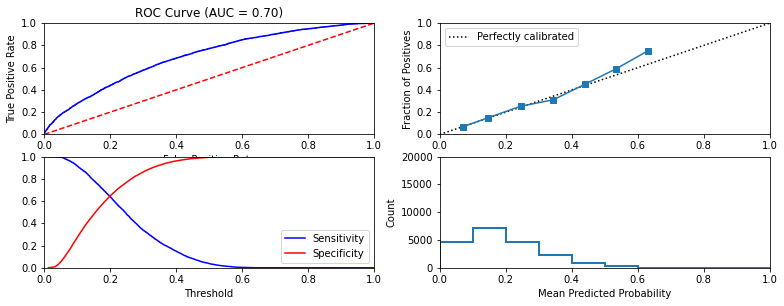


Similarity to LC grade ranking:  0.6921787413013872
Brier score: 0.1437347930735306
Were parameters on edge? : False
Score variations around CV search grid : 0.21445067634444462
[0.80653333 0.80826667 0.80783333 0.8079     0.80786667 0.80786667]


In [ ]:
## Train and test a l_1 regularized logistic regression classifier
l2_logistic = LogisticRegression(penalty='l2', solver='liblinear')
cv_parameters = {'C':[0.01, 0.1, 1, 10, 100, 1000]}

l2_logistic = fit_classification(l2_logistic, data_dict, cv_parameters, model_name='l2 Regularized Logistic Regression')

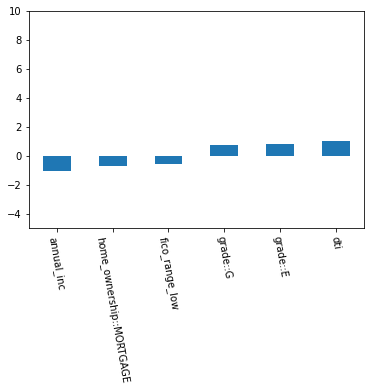

In [ ]:
## plot top 3 features with the most positive (and negative) weights 
top_and_bottom_idx = list(np.argsort(l2_logistic['model'].coef_)[0,:3]) + list(np.argsort(l2_logistic['model'].coef_)[0,-3:])
bplot = pd.Series(l2_logistic['model'].coef_[0,top_and_bottom_idx])
xticks = selected_features[top_and_bottom_idx]
p1 = bplot.plot(kind='bar',rot=-80,ylim=(-5,10))
p1.set_xticklabels(xticks)
plt.show()

### Decision tree

  Model: Decision Tree
Fit time: 534.81 seconds
Optimal parameters:
{'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}

Accuracy-maximizing threshold was: 1
Recall:  0.0
              precision    recall  f1-score   support

  No default     0.8061    1.0000    0.8926     16122
     Default     0.0000    0.0000    0.0000      3878

    accuracy                         0.8061     20000
   macro avg     0.4031    0.5000    0.4463     20000
weighted avg     0.6498    0.8061    0.7196     20000



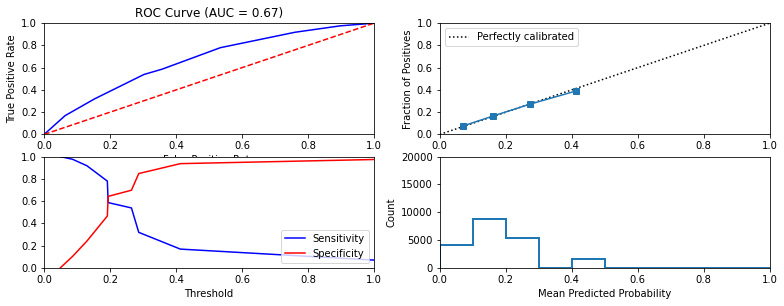


Similarity to LC grade ranking:  0.7166416411087408
Brier score: 0.14762531003993418
Were parameters on edge? : True
Score variations around CV search grid : nan
[       nan        nan 0.80056667 0.80056667 0.80056667 0.80056667
 0.80056667 0.80056667 0.80056667 0.80056667        nan        nan
 0.80056667 0.80056667 0.80056667 0.80056667 0.80056667 0.80056667
 0.80056667 0.80056667        nan        nan 0.80056667 0.80056667
 0.80056667 0.80056667 0.80056667 0.80056667 0.80056667 0.80056667
        nan        nan 0.80056667 0.80056667 0.80056667 0.80056667
 0.80056667 0.80056667 0.80056667 0.80056667        nan        nan
 0.78616667 0.78653333 0.78623333 0.78606667 0.78686667 0.78616667
 0.78623333 0.78606667        nan        nan 0.7858     0.7858
 0.7858     0.7858     0.78563333 0.78563333 0.78563333 0.78563333
        nan        nan 0.78563333 0.78563333 0.78563333 0.78563333
 0.78563333 0.78563333 0.78563333 0.78563333        nan        nan
 0.78546667 0.78546667 0.78546667 0.7

In [ ]:
# Train and test a decision tree classifier
# Source: https://ai.plainenglish.io/hyperparameter-tuning-of-decision-tree-classifier-using-gridsearchcv-2a6ebcaffeda

decision_tree = DecisionTreeClassifier()
cv_parameters = {'max_depth':[3, 5, 7, 9],
                'criterion': ['gini', 'entropy'], 
                'min_samples_split': range(0,10),
                'min_samples_leaf': range(1,5)}

decision_tree = fit_classification(decision_tree, data_dict, cv_parameters, model_name = 'Decision Tree')

### Random forest

  Model: Random Forest
Fit time: 1835.01 seconds
Optimal parameters:
{'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 9}

Accuracy-maximizing threshold was: 0.3570852706790601
Recall:  0.12171222279525529
              precision    recall  f1-score   support

  No default     0.8211    0.9698    0.8893     16122
     Default     0.4922    0.1217    0.1952      3878

    accuracy                         0.8054     20000
   macro avg     0.6567    0.5458    0.5422     20000
weighted avg     0.7573    0.8054    0.7547     20000



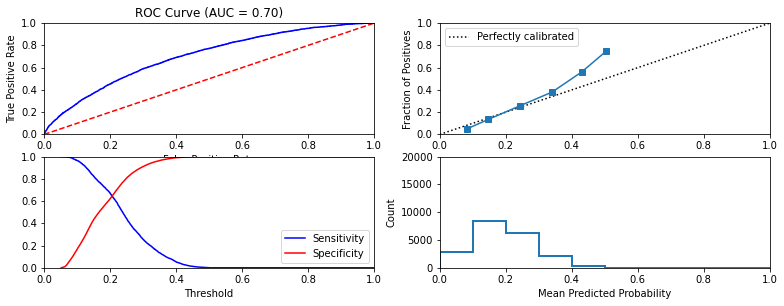


Similarity to LC grade ranking:  0.7418194128274741
Brier score: 0.1441277361112696
Were parameters on edge? : True
Score variations around CV search grid : nan
[       nan        nan 0.80546667 0.80546667 0.80546667 0.80546667
 0.80546667 0.80546667 0.80546667 0.80546667        nan        nan
 0.80546667 0.80546667 0.80546667 0.80546667 0.80546667 0.80546667
 0.80546667 0.80546667        nan        nan 0.80546667 0.80546667
 0.80546667 0.80546667 0.80546667 0.80546667 0.80546667 0.80546667
        nan        nan 0.80546667 0.80546667 0.80546667 0.80546667
 0.80546667 0.80546667 0.80546667 0.80546667        nan        nan
 0.80546667 0.80546667 0.80546667 0.80546667 0.80546667 0.80546667
 0.80546667 0.80546667        nan        nan 0.80546667 0.80546667
 0.80546667 0.80546667 0.80546667 0.80546667 0.80546667 0.80546667
        nan        nan 0.80546667 0.80546667 0.80546667 0.80546667
 0.80546667 0.80546667 0.80546667 0.80546667        nan        nan
 0.80546667 0.80546667 0.80546667 

In [ ]:
## Train and test a random forest classifier

# njobs -1 means process on all cores... was taking forever otherwise
random_forest = RandomForestClassifier(n_jobs = -1)

cv_parameters = {'max_depth':[3, 5, 7],
                'criterion': ['gini', 'entropy'], 
                'min_samples_split': range(0,10),
                'min_samples_leaf': range(1,5),
                }

random_forest = fit_classification(random_forest, data_dict, cv_parameters, model_name = 'Random Forest')

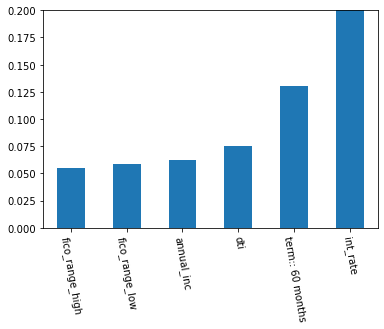

In [ ]:
## Plot top 6 most significant features
top_idx = list(np.argsort(random_forest['model'].feature_importances_)[-6:]) 
bplot = pd.Series(random_forest['model'].feature_importances_[top_idx])
xticks = selected_features[top_idx]
p2 = bplot.plot(kind='bar',rot=-80,ylim=(0,0.2))
p2.set_xticklabels(xticks)
plt.show()

### Multi-layer perceptron

  Model: Multi-layer perceptron
Fit time: 1837.18 seconds
Optimal parameters:
{'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': (20,), 'learning_rate': 'constant', 'solver': 'adam'}

Accuracy-maximizing threshold was: 0.4725947282637024
Recall:  0.037132542547705004
              precision    recall  f1-score   support

  No default     0.8111    0.9945    0.8935     16122
     Default     0.6207    0.0371    0.0701      3878

    accuracy                         0.8089     20000
   macro avg     0.7159    0.5158    0.4818     20000
weighted avg     0.7742    0.8089    0.7338     20000



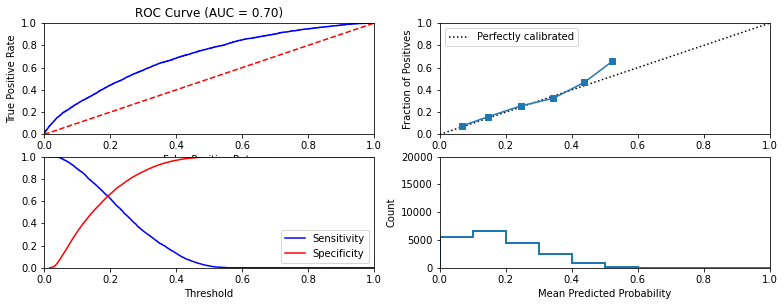


Similarity to LC grade ranking:  0.6902752135074725
Brier score: 0.14392647937960956
Were parameters on edge? : True
Score variations around CV search grid : 1.0359914148918838
[0.80713333 0.80293333 0.8068     0.79923333 0.80733333 0.8049
 0.8061     0.80243333 0.80703333 0.80726667 0.80693333 0.8064
 0.8071     0.80713333 0.80746667 0.80746667 0.80573333 0.79936667
 0.8059     0.79976667 0.80713333 0.80166667 0.8062     0.80186667
 0.8064     0.80323333 0.806      0.80486667 0.80576667 0.806
 0.80626667 0.80536667 0.80546667 0.8063     0.80546667 0.80633333
 0.80546667 0.8076     0.80546667 0.80716667 0.80546667 0.80643333
 0.80546667 0.8065     0.80546667 0.80686667 0.80546667 0.80736667]


In [ ]:
# Train and test a multi-layer perceptron classifier
# Source: https://panjeh.medium.com/scikit-learn-hyperparameter-optimization-for-mlpclassifier-4d670413042b

mlp = MLPClassifier()
cv_parameters = {'hidden_layer_sizes': [(10,30,10),(20,)],
                 'activation': ['tanh', 'relu', 'logistic'],
                 'solver': ['sgd', 'adam'],
                 'alpha': [0.0001, 0.05],
                 'learning_rate': ['constant','adaptive']
                }

mlp = fit_classification(mlp, data_dict, cv_parameters, model_name = 'Multi-layer perceptron')

## 3.ii. Train and Test logistic regression model with features derived by LendingClub

  Model: Only Grade - l1 Regularized Logistic Regression
Fit time: 0.68 seconds
Optimal parameters:
{'C': 0.01}

Accuracy-maximizing threshold was: 1
Recall:  0.0
              precision    recall  f1-score   support

  No default     0.8061    1.0000    0.8926     16122
     Default     0.0000    0.0000    0.0000      3878

    accuracy                         0.8061     20000
   macro avg     0.4031    0.5000    0.4463     20000
weighted avg     0.6498    0.8061    0.7196     20000



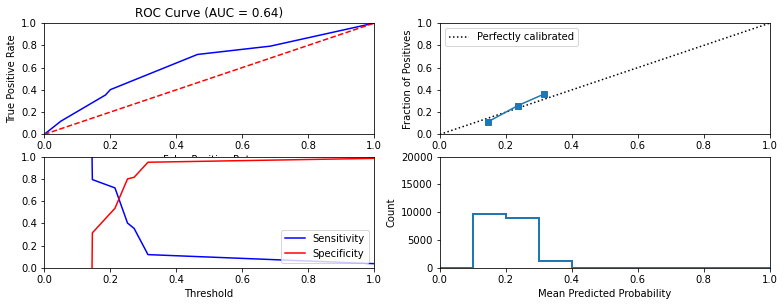


Similarity to LC grade ranking:  0.6833463888312478
Brier score: 0.1497074263440674
Were parameters on edge? : True
Score variations around CV search grid : 0.0
[0.80546667 0.80546667 0.80546667 0.80546667 0.80546667 0.80546667]


In [ ]:
## Find a lendingClub-defined feature and train a l1-regularized logistic regression model on data with only that feature
a_lendingclub_feature = 'grade'

data_dict = prepare_data(feature_subset = a_lendingclub_feature)
lc1_only_logistic = LogisticRegression(penalty='l1', solver='liblinear')
cv_parameters = {'C':[0.01, 0.1, 1, 10, 100, 1000]}

lc1_only_logistic = fit_classification(lc1_only_logistic, data_dict, cv_parameters, model_name='Only Grade - l1 Regularized Logistic Regression')

  Model: Only Grade - l2 Regularized Logistic Regression
Fit time: 0.48 seconds
Optimal parameters:
{'C': 0.01}

Accuracy-maximizing threshold was: 1
Recall:  0.0
              precision    recall  f1-score   support

  No default     0.8061    1.0000    0.8926     16122
     Default     0.0000    0.0000    0.0000      3878

    accuracy                         0.8061     20000
   macro avg     0.4031    0.5000    0.4463     20000
weighted avg     0.6498    0.8061    0.7196     20000



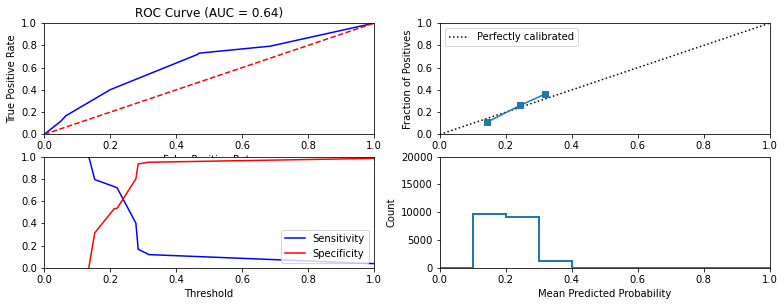


Similarity to LC grade ranking:  0.7023150890457355
Brier score: 0.1494565112766282
Were parameters on edge? : True
Score variations around CV search grid : 0.0
[0.80546667 0.80546667 0.80546667 0.80546667 0.80546667 0.80546667]


In [ ]:
## train a l2-regularized logistic regression model on data with only that feature
lc2_only_logistic = LogisticRegression(penalty='l2', solver='liblinear')
cv_parameters = {'C':[0.01, 0.1, 1, 10, 100, 1000]}

lc2_only_logistic = fit_classification(lc2_only_logistic, data_dict, cv_parameters, model_name='Only Grade - l2 Regularized Logistic Regression')

## 3.iii. Train and test all the models you have tried previously after removing features derived by LendingClub 

### Running a classification model on the 100 Train/Test Splits

In [ ]:
def best_params_fit_classification(model, data_dict,
                          cv_parameters = {},
                          model_name = None,
                          random_state = default_seed,
                          output_to_file = True,
                          print_to_screen = True):
    '''
    This function will fit a classification model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
    
    If the model provided does not have a predict_proba function, we will
    simply print accuracy diagnostics and return.
    
    If the model provided does have a predict_proba function, we first
    figure out the optimal threshold that maximizes the accuracy and
    print out accuracy diagnostics. We then print an ROC curve, sensitivity/
    specificity curve, and calibration curve.
    
    This function returns a dictionary with the following entries
      - model: the best fitted model
      - y_pred: predictions for the test set
      - y_pred_probs: probability predictions for the test set, if the model
                      supports them
      - y_pred_score: prediction scores for the test set, if the model does not 
                      output probabilities.
    '''
        
    np.random.seed(random_state)
    
    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    X_train = data_dict['X_train']
    y_train = data_dict['y_train']
    
    X_test = data_dict['X_test']
    y_test = data_dict['y_test']
    
    filter_train = data_dict['train_set']    
  
    # --------------------------
    #   Step 2 - Fit the model
    # --------------------------

    cv_model = GridSearchCV(model, cv_parameters)
    
    start_time = time.time()
    cv_model.fit(X_train, y_train)
    end_time = time.time()
    
    best_model = cv_model.best_estimator_
    
    if print_to_screen:

        if model_name != None:
            print("=========================================================")
            print("  Model: " + model_name)
            print("=========================================================")

        print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
        print("Optimal parameters:")
        print(cv_model.best_params_)
        print("")
    
    # -------------------------------
    #   Step 3 - Evaluate the model
    # -------------------------------
    
    # If possible, make probability predictions
    try:
        y_pred_probs = best_model.predict_proba(X_test)[:,1]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
        
        probs_predicted = True
    except:
        probs_predicted = False
    
    # Make predictions; if we were able to find probabilities, use
    # the threshold that maximizes the accuracy in the training set.
    # If not, just use the learner's predict function
    if probs_predicted:
        y_train_pred_probs = best_model.predict_proba(X_train)[:,1]
        fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_probs)
        
        true_pos_train = tpr_train*(y_train.sum())
        true_neg_train = (1 - fpr_train) *(1-y_train).sum()
        
        best_threshold_index = np.argmax(true_pos_train + true_neg_train)
        best_threshold = 1 if best_threshold_index == 0 else thresholds_train[ best_threshold_index ]
        
        if print_to_screen:
            print("Accuracy-maximizing threshold was: " + str(best_threshold))
        
        y_pred = (y_pred_probs > best_threshold)
    else:
        y_pred = best_model.predict(X_test)
    
    if print_to_screen:
        print("Recall: ", recall_score(y_test, y_pred))
        print(classification_report(y_test, y_pred, target_names =['No default', 'Default'], digits = 4))

    if print_to_screen:
        if probs_predicted:        
            plt.figure(figsize = (13, 4.5))
            plt.subplot(2, 2, 1)

            plt.title("ROC Curve (AUC = %0.2f)"% roc_auc_score(y_test, y_pred_probs))
            plt.plot(fpr, tpr, 'b')
            plt.plot([0,1],[0,1],'r--')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')

            plt.subplot(2, 2, 3)

            plt.plot(thresholds, tpr, 'b', label = 'Sensitivity')
            plt.plot(thresholds, 1 -fpr, 'r', label = 'Specificity')
            plt.legend(loc = 'lower right')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.xlabel('Threshold')

            plt.subplot(2, 2, 2)

            fp_0, mpv_0 = calibration_curve(y_test, y_pred_probs, n_bins = 10)
            plt.plot([0,1], [0,1], 'k:', label='Perfectly calibrated')
            plt.plot(mpv_0, fp_0, 's-')
            plt.ylabel('Fraction of Positives')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.legend(loc ='upper left')
            
            plt.subplot(2, 2, 4)
            plt.hist(y_pred_probs, range=(0, 1), bins=10, histtype="step", lw=2)
            plt.xlim([0,1]); plt.ylim([0,20000])
            plt.xlabel('Mean Predicted Probability')
            plt.ylabel('Count')
            
            #plt.tight_layout()
            plt.show()
        
    # Additional Score Check
    if probs_predicted:
        y_train_score = y_train_pred_probs
    else:
        y_train_score = best_model.decision_function(X_train)
        
    tau, p_value = kendalltau(y_train_score, data.grade[filter_train])
    if print_to_screen:
        print("")
        print("Similarity to LC grade ranking: ", tau)
    
    if probs_predicted:
        brier_score = brier_score_loss(y_test, y_pred_probs)
        if print_to_screen:
            print("Brier score:", brier_score)
    
    # Return the model predictions, and the
    # test set
    # -------------------------------------
    out = {'model':best_model, 'y_pred_labels':y_pred}
    
    if probs_predicted:
        out.update({'y_pred_probs':y_pred_probs})
    else:
        y_pred_score = best_model.decision_function(X_test)
        out.update({'y_pred_score':y_pred_score})
        
    # Output results to file
    # ----------------------
    if probs_predicted and output_to_file:
        # Check whether any of the CV parameters are on the edge of
        # the search space
        opt_params_on_edge = find_opt_params_on_edge(cv_model)
        dump_to_output(model_name + "::search_on_edge", opt_params_on_edge)
        if print_to_screen:
            print("Were parameters on edge? : " + str(opt_params_on_edge))
        
        # Find out how different the scores are for the different values
        # tested for by cross-validation. If they're not too different, then
        # even if the parameters are off the edge of the search grid, we should
        # be ok
        score_variation = find_score_variation(cv_model)
        dump_to_output(model_name + "::score_variation", score_variation)
        if print_to_screen:
            print("Score variations around CV search grid : " + str(score_variation))
        
        # Print out all the scores
        dump_to_output(model_name + "::all_cv_scores", str(cv_model.cv_results_['mean_test_score']))
        if print_to_screen:
            print( str(cv_model.cv_results_['mean_test_score']) )
        
        # Dump the AUC to file
        dump_to_output(model_name + "::roc_auc", roc_auc_score(y_test, y_pred_probs) )
        
    return out

In [ ]:
# Not complete, take a look at avg_metrics_for_hundred_splits_regression 
# need to add averaging w metric
def avg_metrics_for_hundred_splits_classification(model
                                                  , data_dict
                                                  , hundred_train_test_splits
                                                  , model_name): 
    hundred_models_best_params = []

    for random_split in hundred_train_test_splits:
        hundred_models_best_params.append(best_params_fit_classification(model, 
                                                                    random_split, 
                                                                    output_to_file=False, 
                                                                    print_to_screen=False))
    accuracies = []
    for h in hundred_models_best_params:
        accuracies.append(recall_score(data_dict['y_test'], h['y_pred_labels']))
    
    avg = np.mean(accuracies)
    std = np.std(accuracies)
    
    print("{}: {} +/- {}".format(model_name, avg, std))

In [ ]:
from sklearn.dummy import DummyClassifier

# Best models
dc = DummyClassifier()
gnb = GaussianNB(var_smoothing=0.657933224657568)
l1_logistic = LogisticRegression(penalty='l1', solver='liblinear', C=0.1)
l2_logistic = LogisticRegression(penalty='l2', solver='liblinear', C=0.2)
decision_tree = DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=1, min_samples_split=2)
random_forest = RandomForestClassifier(criterion='gini', max_depth=7, min_samples_leaf=2, min_samples_split=9, n_jobs=-1)
mlp = MLPClassifier(activation='logistic', alpha=0.0001, hidden_layer_sizes=(20,), learning_rate='constant', solver='adam')

In [ ]:
# Remove LendingClub derived features
removed_features = ['grade', 'dti', 'verification_status', 'dti', 'revol_util', 'loan_status']
your_features = set(your_features) - set(removed_features)

# Prepare the train, test data for training models with new features
data_dict = prepare_data(feature_subset = your_features)

avg_metrics_for_hundred_splits_classification(dc, data_dict, hundred_train_test_splits, 'Dummy Classifier')
avg_metrics_for_hundred_splits_classification(gnb, data_dict, hundred_train_test_splits, 'Naive Bayes Classifier')
avg_metrics_for_hundred_splits_classification(l1_logistic, data_dict, hundred_train_test_splits, 'L1-Logistic Classifier')
avg_metrics_for_hundred_splits_classification(l2_logistic, data_dict, hundred_train_test_splits, 'L2-Logistic Classifier')
avg_metrics_for_hundred_splits_classification(decision_tree, data_dict, hundred_train_test_splits, 'Decision Tree Classifier')
avg_metrics_for_hundred_splits_classification(random_forest, data_dict, hundred_train_test_splits, 'Random Forest Classifier')
avg_metrics_for_hundred_splits_classification(mlp, data_dict, hundred_train_test_splits, 'Multi-layer Perceptron Classifier')

# Prints average recall +/- standard deviation of 100 random fits

Dummy Classifier: 0.0 +/- 0.0
Naive Bayes Classifier: 0.0067534811758638465 +/- 0.005543278661864567
L1-Logistic Classifier: 0.015407426508509544 +/- 0.00805491420273299
L2-Logistic Classifier: 0.01594636410520887 +/- 0.007461855740788212
Decision Tree Classifier: 0.0 +/- 0.0
Random Forest Classifier: 0.04000773594636411 +/- 0.007651713931465534
Multi-layer Perceptron Classifier: 0.015843218153687465 +/- 0.007427611516278324


## YOUR MODEL

  Model: Random Forest
Fit time: 4.34 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 0.3852473097556261
Recall:  0.08612686952037132
              precision    recall  f1-score   support

  No default     0.8170    0.9815    0.8917     16122
     Default     0.5276    0.0861    0.1481      3878

    accuracy                         0.8078     20000
   macro avg     0.6723    0.5338    0.5199     20000
weighted avg     0.7609    0.8078    0.7475     20000



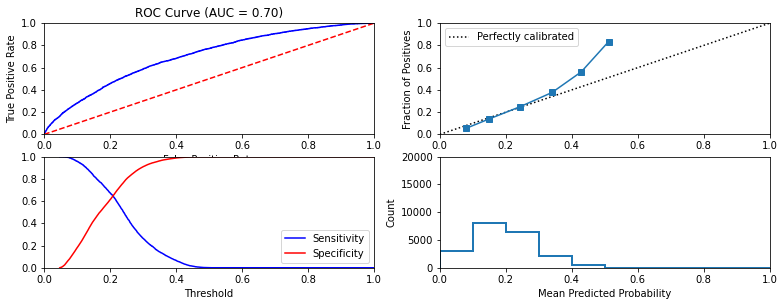


Similarity to LC grade ranking:  0.7583634697220473
Brier score: 0.14398530635959206
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.80536667]


In [25]:
# best parameters = {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 9}

model = RandomForestClassifier(criterion='gini', max_depth=7, min_samples_leaf=2, min_samples_split=9, n_jobs=-1)
your_model = fit_classification(model, data_dict, model_name = 'Random Forest')

## 4. YOURMODEL grades analysis

In [ ]:
# Grades table
y_test_grades = pd.DataFrame(list(zip(
    # this is the loan grade
    data_dict['test_data'][:,5]
    # this is the predicted label
    , your_model['y_pred_labels']
    # this is the actual label
    ,((data_dict['test_data'][:,11] == 'Charged Off') | (data_dict['test_data'][:,11] == 'Default')))))
y_test_grades.columns = ['grade', 'y_pred', 'y_actual']

print('\n\nloan percentages in each grade for testing data:')
y_test_grades.groupby(by=['grade']).count()/20000*100



loan percentages in each grade for testing data:


,y_pred,y_actual
grade,,
A,18.675,18.675
B,29.335,29.335
C,27.425,27.425
D,15.465,15.465
E,6.375,6.375
F,2.140,2.140
G,0.585,0.585


In [ ]:
print('\n\nEmpiracle percentage of loans that defaulted in each grade for test set:')
empiracleDefault = pd.DataFrame(y_test_grades.groupby(by='grade').apply(lambda x : (x.y_actual == True).sum()*100/len(x)))
empiracleDefault = empiracleDefault.reset_index()
empiracleDefault = empiracleDefault.rename(columns={0:'Empiracle Pct Default'})
empiracleDefault



Empiracle percentage of loans that defaulted in each grade for test set:


,grade,Empiracle Pct Default
0,A,6.586345
1,B,13.652633
2,C,22.370100
3,D,29.518267
4,E,36.078431
5,F,43.691589
6,G,37.606838


In [ ]:
print('\n\nPredicted percentage of loans that defaulted in each grade for test set:')
predictedDefault = pd.DataFrame(y_test_grades.groupby(by='grade').apply(lambda x : (x.y_pred == True).sum()*100/len(x)))
predictedDefault = predictedDefault.reset_index()
predictedDefault = predictedDefault.rename(columns={0:'Predicted Pct Default'})
predictedDefault



Predicted percentage of loans that defaulted in each grade for test set:


,grade,Predicted Pct Default
0,A,0.000000
1,B,0.000000
2,C,1.257976
3,D,7.371484
4,E,16.392157
5,F,23.364486
6,G,30.769231


In [ ]:
print('\n\nSummary of Grade Analysis:')

summaryDefaults = pd.DataFrame()
summaryDefaults = pd.merge(
                            empiracleDefault,
                            predictedDefault,
                            how="inner",
                            on='grade',
                            left_on=None,
                            right_on=None,
                            left_index=False,
                            right_index=False,
                            sort=True,
                            suffixes=("_x", "_y"),
                            copy=True,
                            indicator=False,
                            validate=None,)

summaryDefaults



Summary of Grade Analysis:


,grade,Empiracle Pct Default,Predicted Pct Default
0,A,6.586345,0.000000
1,B,13.652633,0.000000
2,C,22.370100,1.257976
3,D,29.518267,7.371484
4,E,36.078431,16.392157
5,F,43.691589,23.364486
6,G,37.606838,30.769231


## Time stability test of YOURMODEL

  Model: Random Forest (2010)
Fit time: 2.37 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 0.2469472876711781
Recall:  0.1274131274131274
              precision    recall  f1-score   support

  No default     0.8791    0.9437    0.9102      1741
     Default     0.2519    0.1274    0.1692       259

    accuracy                         0.8380      2000
   macro avg     0.5655    0.5356    0.5397      2000
weighted avg     0.7979    0.8380    0.8143      2000



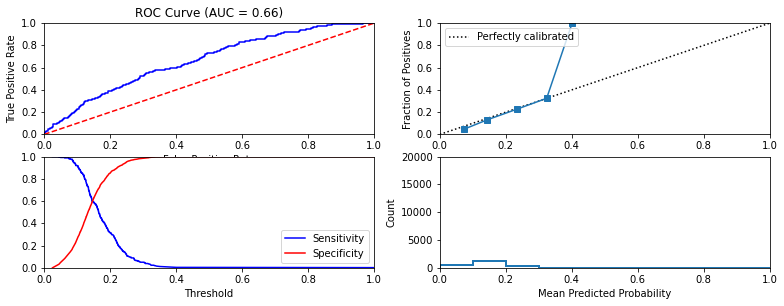


Similarity to LC grade ranking:  0.6359390445395932
Brier score: 0.10851787168558623
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.87657143]
  Model: Random Forest (2016)
Fit time: 1.89 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 0.3684070747240593
Recall:  0.19790104947526238
              precision    recall  f1-score   support

  No default     0.8818    0.9208    0.9009      4333
     Default     0.2779    0.1979    0.2312       667

    accuracy                         0.8244      5000
   macro avg     0.5798    0.5594    0.5660      5000
weighted avg     0.8012    0.8244    0.8115      5000



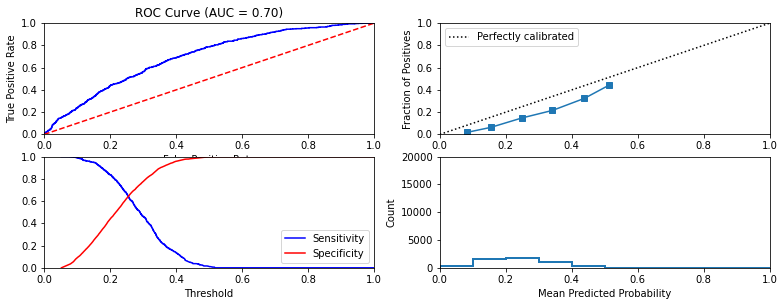


Similarity to LC grade ranking:  0.6665400147628532
Brier score: 0.11970723499408527
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.7623]


{'model': RandomForestClassifier(max_depth=7, min_samples_leaf=2, min_samples_split=9,
                        n_jobs=-1),
 'y_pred_labels': array([False,  True, False, ..., False, False, False]),
 'y_pred_probs': array([0.23790646, 0.45843559, 0.09849248, ..., 0.06147652, 0.34571771,
        0.1759454 ])}

In [ ]:
## Define the time window of your train and test data
start_date_train_2010 = datetime.date(2010,1,1) 
end_date_train_2010 = datetime.date(2010,12,31)

start_date_train_2016 = datetime.date(2016,1,1)
end_date_train_2016 = datetime.date(2016,12,31)

start_date_test = datetime.date(2017,1,1)
end_date_test = datetime.date(2017,12,31)

data_dict_test_2010 = prepare_data(date_range_train = (start_date_train_2010, end_date_train_2010), 
                         date_range_test = (start_date_test, end_date_test),
                         n_samples_train = 7000, n_samples_test = 2000, feature_subset = your_features)
data_dict_test_2016 = prepare_data(date_range_train = (start_date_train_2016, end_date_train_2016), 
                         date_range_test = (start_date_test, end_date_test),
                         n_samples_train = 20000, n_samples_test = 5000, feature_subset = your_features)

## Train and test YOURMODEL using this data
fit_classification(your_model['model'], data_dict_test_2010, model_name = 'Random Forest (2010)')
fit_classification(your_model['model'], data_dict_test_2016, model_name = 'Random Forest (2016)')

## Train and test YOURMODEL on the original data

In [ ]:
# Import original original data and run through prepare_data & fit_classification
original_data = pickle.load( open( "original_data.pickle", "rb" ) )

In [ ]:
your_features = ['addr_state',
    'annual_inc',
    'application_type',
    'delinq_2yrs',
    'dti',
    'earliest_cr_line',
    'emp_length',
    'emp_title',
    'fico_range_high',
    'fico_range_low',
    'funded_amnt',
    'funded_amnt_inv',
    'grade',
    'home_ownership',
    'id',
    'installment',
    'int_rate',
    'issue_d',
    'last_fico_range_high',
    'last_fico_range_low',
    'last_pymnt_amnt',
    'last_pymnt_d',
    'loan_amnt',
    'loan_status', 
    'open_acc',
    'pub_rec',
    'purpose',
    'recoveries',
    'revol_bal',
    'revol_util',
    'sub_grade',
    'term',
    'title',
    'total_pymnt',
    'verification_status',
    'zip_code']

float_cols = ['last_pymnt_amnt', 'last_fico_range_high', 'last_fico_range_low', 'installment', 'id', 'funded_amnt_inv'
              , 'loan_amnt', 'funded_amnt', 'annual_inc', 'dti', 'delinq_2yrs', 'open_acc', 'pub_rec'
              , 'fico_range_high', 'fico_range_low', 'revol_bal', 'total_pymnt', 'recoveries']
cat_cols = ['zip_code', 'title', 'loan_status', 'sub_grade', 'emp_title', 'application_type', 'addr_state', 'term', 'grade', 'emp_length', 'home_ownership'
            , 'verification_status', 'purpose'] 
perc_cols = ['int_rate', 'revol_util']
date_cols = ['issue_d', 'earliest_cr_line', 'last_pymnt_d']

continuous_features = ['last_pymnt_amnt', 'last_fico_range_high', 'last_fico_range_low', 'installment', 'id', 'funded_amnt_inv'
              , 'loan_amnt', 'funded_amnt', 'annual_inc', 'dti', 'delinq_2yrs', 'open_acc', 'pub_rec'
              , 'fico_range_high', 'fico_range_low', 'revol_bal', 'total_pymnt', 'recoveries', 'int_rate', 'revol_util']
discrete_features = ['addr_state', 'term', 'grade', 'emp_length', 'home_ownership', 'verification_status', 'purpose'
           , 'sub_grade'] # categorical features


In [ ]:
# Reduce features
continuous_features = list(set(continuous_features) - set(['cr_hist']))
original_data = original_data[your_features]

In [ ]:
# Typecasting 

# FLOATS #

for i in float_cols:
    original_data[i] = pd.to_numeric(original_data[i], downcast='float') # typecast float columns
    
# PERCENT #

def clean_perc(x):
    if pd.isnull(x):
        return np.nan
    else:
        return float(x.strip()[:-1])

for i in perc_cols:
    original_data[i] = [clean_perc(x) for x in original_data[i]] # apply clean_perc to percentage columns
    
# DATES #

def clean_date(x):
    if pd.isnull(x):
        return None
    else:
        return datetime.datetime.strptime(x, "%b-%Y").date()

for i in date_cols:
    original_data[i] = [clean_date(x) for x in original_data[i]] # typecast date columns to datatime using clean_date
    
# CATEGORICAL #
# null and empty values are already set to NaN. No filling needed. 

for i in cat_cols:
    original_data[i] = original_data[i].fillna("None") 

In [ ]:
# Create outcome and training columns
original_data["outcome"] = ((original_data['loan_status'] == 'Charged Off') | (original_data['loan_status'] == 'Default'))
original_indices = np.random.choice(range(len(original_data)), int(0.7*len(original_data)), replace=False)
original_data['train'] = False
original_data['train'].iloc[list(original_indices)] = True

# Create continuous and discrete datasets
X_original_continuous = original_data[continuous_features].to_numpy()
X_original_discrete = pd.get_dummies(original_data[discrete_features], dummy_na = True, prefix_sep = "::", drop_first = True)
original_discrete_features_dummies = X_original_discrete.columns.tolist()
X_original_discrete = X_original_discrete.values

In [ ]:
# Impute missing variables as 0
X_original_continuous = np.nan_to_num(X_original_continuous)

In [ ]:
# Drop data leakage columns
original_data = original_data.drop(columns=['loan_status', 'total_pymnt', 'last_pymnt_d', 'id', 'recoveries'])

In [ ]:
def original_fit_classification(model, data_dict,
                          cv_parameters = {},
                          model_name = None,
                          random_state = default_seed,
                          output_to_file = True,
                          print_to_screen = True):
    '''
    This function will fit a classification model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
    
    If the model provided does not have a predict_proba function, we will
    simply print accuracy diagnostics and return.
    
    If the model provided does have a predict_proba function, we first
    figure out the optimal threshold that maximizes the accuracy and
    print out accuracy diagnostics. We then print an ROC curve, sensitivity/
    specificity curve, and calibration curve.
    
    This function returns a dictionary with the following entries
      - model: the best fitted model
      - y_pred: predictions for the test set
      - y_pred_probs: probability predictions for the test set, if the model
                      supports them
      - y_pred_score: prediction scores for the test set, if the model does not 
                      output probabilities.
    '''
        
    np.random.seed(random_state)
    
    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    X_train = data_dict['X_train']
    y_train = data_dict['y_train']
    
    X_test = data_dict['X_test']
    y_test = data_dict['y_test']
    
    filter_train = data_dict['train_set']    
  
    # --------------------------
    #   Step 2 - Fit the model
    # --------------------------

    cv_model = GridSearchCV(model, cv_parameters)
    
    start_time = time.time()
    cv_model.fit(X_train, y_train)
    end_time = time.time()
    
    best_model = cv_model.best_estimator_
    
    if print_to_screen:

        if model_name != None:
            print("=========================================================")
            print("  Model: " + model_name)
            print("=========================================================")

        print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
        print("Optimal parameters:")
        print(cv_model.best_params_)
        print("")
    
    # -------------------------------
    #   Step 3 - Evaluate the model
    # -------------------------------
    
    # If possible, make probability predictions
    try:
        y_pred_probs = best_model.predict_proba(X_test)[:,1]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
        
        probs_predicted = True
    except:
        probs_predicted = False
    
    # Make predictions; if we were able to find probabilities, use
    # the threshold that maximizes the accuracy in the training set.
    # If not, just use the learner's predict function
    if probs_predicted:
        y_train_pred_probs = best_model.predict_proba(X_train)[:,1]
        fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_probs)
        
        true_pos_train = tpr_train*(y_train.sum())
        true_neg_train = (1 - fpr_train) *(1-y_train).sum()
        
        best_threshold_index = np.argmax(true_pos_train + true_neg_train)
        best_threshold = 1 if best_threshold_index == 0 else thresholds_train[ best_threshold_index ]
        
        if print_to_screen:
            print("Accuracy-maximizing threshold was: " + str(best_threshold))
        
        y_pred = (y_pred_probs > best_threshold)
    else:
        y_pred = best_model.predict(X_test)
    
    if print_to_screen:
        print("Recall: ", recall_score(y_test, y_pred))
        print(classification_report(y_test, y_pred, target_names =['No default', 'Default'], digits = 4))

    if print_to_screen:
        if probs_predicted:        
            plt.figure(figsize = (13, 4.5))
            plt.subplot(2, 2, 1)

            plt.title("ROC Curve (AUC = %0.2f)"% roc_auc_score(y_test, y_pred_probs))
            plt.plot(fpr, tpr, 'b')
            plt.plot([0,1],[0,1],'r--')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')

            plt.subplot(2, 2, 3)

            plt.plot(thresholds, tpr, 'b', label = 'Sensitivity')
            plt.plot(thresholds, 1 -fpr, 'r', label = 'Specificity')
            plt.legend(loc = 'lower right')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.xlabel('Threshold')

            plt.subplot(2, 2, 2)

            fp_0, mpv_0 = calibration_curve(y_test, y_pred_probs, n_bins = 10)
            plt.plot([0,1], [0,1], 'k:', label='Perfectly calibrated')
            plt.plot(mpv_0, fp_0, 's-')
            plt.ylabel('Fraction of Positives')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.legend(loc ='upper left')
            
            plt.subplot(2, 2, 4)
            plt.hist(y_pred_probs, range=(0, 1), bins=10, histtype="step", lw=2)
            plt.xlim([0,1]); plt.ylim([0,20000])
            plt.xlabel('Mean Predicted Probability')
            plt.ylabel('Count')
            
            #plt.tight_layout()
            plt.show()
        
    # Additional Score Check
    if probs_predicted:
        y_train_score = y_train_pred_probs
    else:
        y_train_score = best_model.decision_function(X_train)
        
    tau, p_value = kendalltau(y_train_score, original_data.grade[filter_train]) ## Call original not data
    if print_to_screen:
        print("")
        print("Similarity to LC grade ranking: ", tau)
    
    if probs_predicted:
        brier_score = brier_score_loss(y_test, y_pred_probs)
        if print_to_screen:
            print("Brier score:", brier_score)
    
    # Return the model predictions, and the
    # test set
    # -------------------------------------
    out = {'model':best_model, 'y_pred_labels':y_pred}
    
    if probs_predicted:
        out.update({'y_pred_probs':y_pred_probs})
    else:
        y_pred_score = best_model.decision_function(X_test)
        out.update({'y_pred_score':y_pred_score})
        
    # Output results to file
    # ----------------------
    if probs_predicted and output_to_file:
        # Check whether any of the CV parameters are on the edge of
        # the search space
        opt_params_on_edge = find_opt_params_on_edge(cv_model)
        dump_to_output(model_name + "::search_on_edge", opt_params_on_edge)
        if print_to_screen:
            print("Were parameters on edge? : " + str(opt_params_on_edge))
        
        # Find out how different the scores are for the different values
        # tested for by cross-validation. If they're not too different, then
        # even if the parameters are off the edge of the search grid, we should
        # be ok
        score_variation = find_score_variation(cv_model)
        dump_to_output(model_name + "::score_variation", score_variation)
        if print_to_screen:
            print("Score variations around CV search grid : " + str(score_variation))
        
        # Print out all the scores
        dump_to_output(model_name + "::all_cv_scores", str(cv_model.cv_results_['mean_test_score']))
        if print_to_screen:
            print( str(cv_model.cv_results_['mean_test_score']) )
        
        # Dump the AUC to file
        dump_to_output(model_name + "::roc_auc", roc_auc_score(y_test, y_pred_probs) )
        
    return out

  Model: Random Forest (Original Data)
Fit time: 5.33 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 0.4837927710450953
Recall:  0.6244158878504673
              precision    recall  f1-score   support

  No default     0.9655    0.9845    0.9749     18288
     Default     0.7901    0.6244    0.6976      1712

    accuracy                         0.9536     20000
   macro avg     0.8778    0.8044    0.8362     20000
weighted avg     0.9505    0.9536    0.9512     20000



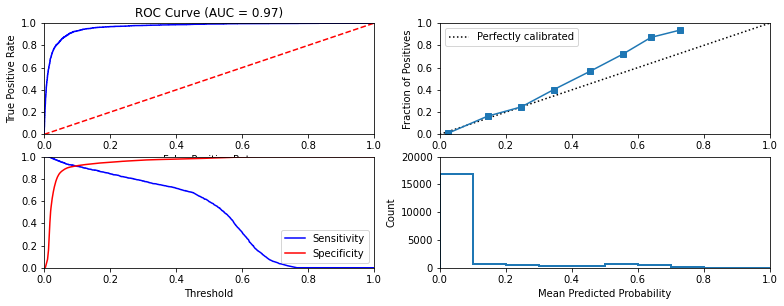


Similarity to LC grade ranking:  0.3180748874544905
Brier score: 0.03650054846948019
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.92176667]


{'model': RandomForestClassifier(max_depth=7, min_samples_leaf=2, min_samples_split=9,
                        n_jobs=-1),
 'y_pred_labels': array([False, False, False, ..., False, False, False]),
 'y_pred_probs': array([0.07574872, 0.32812928, 0.04752843, ..., 0.01620839, 0.01444367,
        0.01285873])}

In [ ]:
original_X = np.concatenate( (X_original_continuous, X_original_discrete), axis = 1 )
original_y = original_data.outcome.to_numpy()
original_train = original_data.train.to_numpy()

original_data_dict = prepare_data_for_n_test_train_splits(original_data,
                    original_discrete_features_dummies,
                    original_X,
                    original_y,
                    original_train,
                    feature_subset = your_features)
original_fit_classification(your_model['model'], original_data_dict, model_name = 'Random Forest (Original Data)')

## Test regression models

In [16]:
def fit_regression(model, data_dict,
                      cv_parameters = {},
                      separate = False, 
                      model_name = None,
                      random_state = default_seed,
                      output_to_file = True,
                      print_to_screen = True):
    '''
    This function will fit a regression model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - separate: a Boolean variable indicating whether we fit models for 
                  defaulted and non-defaulted loans separately
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over      
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
    
    This function returns a dictionary FOR EACH RETURN DEFINITION with the following entries
      - model: the best fitted model
      - predicted_return: prediction result based on the test set
      - predicted_regular_return: prediction result for non-defaulted loans (valid if separate == True)
      - predicted_default_return: prediction result for defaulted loans (valid if separate == True)
      - r2_scores: the testing r2_score(s) for the best fitted model
    '''
    
    np.random.seed(random_state)
    
    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    
    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
    
    X_train = data_dict['X_train']
    filter_train = data_dict['train_set']  

    X_test = data_dict['X_test']
    filter_test = data_dict['test_set']
    out = {}
    
    for ret_col in col_list:
        
        y_train = data.loc[filter_train, ret_col].to_numpy()
        y_test = data.loc[filter_test, ret_col].to_numpy()

        # --------------------------
        #   Step 2 - Fit the model
        # --------------------------

        if separate:
            outcome_train = data.loc[filter_train, 'outcome']
            outcome_test = data.loc[filter_test, 'outcome']

            # Train two separate regressors for defaulted and non-defaulted loans
            X_train_0 = X_train[outcome_train == False]
            y_train_0 = y_train[outcome_train == False]
            X_test_0 = X_test[outcome_test == False]
            y_test_0 = y_test[outcome_test == False]

            X_train_1 = X_train[outcome_train == True]
            y_train_1 = y_train[outcome_train == True]
            X_test_1 = X_test[outcome_test == True]
            y_test_1 = y_test[outcome_test == True]

            cv_model_0 = GridSearchCV(model, cv_parameters, scoring='r2')
            cv_model_1 = GridSearchCV(model, cv_parameters, scoring='r2')

            start_time = time.time()
            cv_model_0.fit(X_train_0, y_train_0)
            cv_model_1.fit(X_train_1, y_train_1)
            end_time = time.time()

            best_model_0 = cv_model_0.best_estimator_
            best_model_1 = cv_model_1.best_estimator_
            
            if print_to_screen:

                if model_name != None:
                    print("=========================================================")
                    print("  Model: " + model_name + "  Return column: " + ret_col)
                    print("=========================================================")

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print("model_0:",cv_model_0.best_params_, "model_1",cv_model_1.best_params_)

            predicted_regular_return = best_model_0.predict(X_test)
            predicted_default_return = best_model_1.predict(X_test)
            
            if print_to_screen:
                print("")
                print("Testing r2 scores:")
            # Here we use different testing set to report the performance
            test_scores = {'model_0':r2_score(y_test_0,best_model_0.predict(X_test_0)),
                              'model_1':r2_score(y_test_1,best_model_1.predict(X_test_1))}
            if print_to_screen:
                print("model_0:", test_scores['model_0'])
                print("model_1:", test_scores['model_1'])

            cv_objects = {'model_0':cv_model_0, 'model_1':cv_model_1}
            out[ret_col] = { 'model_0':best_model_0, 'model_1':best_model_1, 'predicted_regular_return':predicted_regular_return,
                      'predicted_default_return':predicted_default_return,'r2_scores':test_scores }

        else:
            cv_model = GridSearchCV(model, cv_parameters, scoring='r2')

            start_time = time.time()
            cv_model.fit(X_train, y_train)
            end_time = time.time()

            best_model = cv_model.best_estimator_
            
            if print_to_screen:
                if model_name != None:
                    print("=========================================================")
                    print("  Model: " + model_name + "  Return column: " + ret_col)
                    print("=========================================================")

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print(cv_model.best_params_)

            predicted_return = best_model.predict(X_test)
            test_scores = {'model':r2_score(y_test,predicted_return)}
            if print_to_screen:
                print("")
                print("Testing r2 score:", test_scores['model'])

            cv_objects = {'model':cv_model}
            out[ret_col] = {'model':best_model, 'predicted_return':predicted_return, 'r2_scores':r2_score(y_test,predicted_return)}

        # Output the results to a file
        if output_to_file:
            for i in cv_objects:
                # Check whether any of the CV parameters are on the edge of
                # the search space
                opt_params_on_edge = find_opt_params_on_edge(cv_objects[i])
                dump_to_output(model_name + "::" + ret_col + "::search_on_edge", opt_params_on_edge)
                if print_to_screen:
                    print("Were parameters on edge (" + i + ") : " + str(opt_params_on_edge))

                # Find out how different the scores are for the different values
                # tested for by cross-validation. If they're not too different, then
                # even if the parameters are off the edge of the search grid, we should
                # be ok
                score_variation = find_score_variation(cv_objects[i])
                dump_to_output(model_name + "::" + ret_col + "::score_variation", score_variation)
                if print_to_screen:
                    print("Score variations around CV search grid (" + i + ") : " + str(score_variation))

                # Print out all the scores
                dump_to_output(model_name + "::all_cv_scores", str(cv_objects[i].cv_results_['mean_test_score']))
                if print_to_screen:
                    print("All test scores : " + str(cv_objects[i].cv_results_['mean_test_score']) )

                # Dump the AUC to file
                dump_to_output( model_name + "::" + ret_col + "::r2", test_scores[i] )

    return out

### $l_1$ regularized linear regression

In [27]:
## First, trying l1 regularized linear regression with hyper-parameters
# says there are continuous features in the dataset still 

cv_parameters = {'alpha' : [1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100]}

reg_lasso = fit_regression(model = linear_model.Lasso(), data_dict = data_dict, cv_parameters=cv_parameters, model_name='L1 Regularization')

  Model: L1 Regularization  Return column: ret_PESS
Fit time: 10.29 seconds
Optimal parameters:
{'alpha': 0.001}

Testing r2 score: 0.012249729062838166
Were parameters on edge (model) : False
Score variations around CV search grid (model) : -9.480315540855411
All test scores : [-0.10172411 -0.10172407 -0.10172084 -0.10046612 -0.10999063 -0.10999063
 -0.10999063 -0.10999063 -0.10999063 -0.10999063 -0.10999063 -0.10999063
 -0.10999063 -0.10999063 -0.10999063 -0.10999063]
  Model: L1 Regularization  Return column: ret_OPT
Fit time: 11.77 seconds
Optimal parameters:
{'alpha': 1e-08}

Testing r2 score: 0.02983268479793766
Were parameters on edge (model) : False
Score variations around CV search grid (model) : 171.08745117957181
All test scores : [ 0.01613392  0.01613393  0.01613457  0.0043736  -0.01146966 -0.01146966
 -0.01146966 -0.01146966 -0.01146966 -0.01146966 -0.01146966 -0.01146966
 -0.01146966 -0.01146966 -0.01146966 -0.01146966]
  Model: L1 Regularization  Return column: ret_INTa


### $l_2$ regularized linear regressor

In [22]:
## trying l2 regularized linear regression with hyper-parameters
cv_parameters = {'alpha' : [1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100, 200, 300, 400, 500, 600, 1000, 1100, 1200, 1300, 1400, 1500]}

reg_ridge= fit_regression(model = linear_model.Ridge(), data_dict = data_dict, cv_parameters=cv_parameters, model_name='L2 Regularization')

  Model: L2 Regularization  Return column: ret_PESS
Fit time: 1.15 seconds
Optimal parameters:
{'alpha': 300}

Testing r2 score: 0.02571756933959113
Were parameters on edge (model) : False
Score variations around CV search grid (model) : -330.81093851998855
All test scores : [-0.39191395 -0.1018468  -0.10184683 -0.10183336 -0.10182651 -0.10119972
 -0.09934751 -0.09777991 -0.09581436 -0.09461547 -0.09417451 -0.09380497
 -0.09349099 -0.09322112 -0.09298694 -0.09177601 -0.09103581 -0.09097122
 -0.09109506 -0.09128673 -0.09150344 -0.09237809 -0.09258133 -0.09277694
 -0.09296508 -0.09314607 -0.09332028]
  Model: L2 Regularization  Return column: ret_OPT
Fit time: 1.14 seconds
Optimal parameters:
{'alpha': 5}

Testing r2 score: 0.029747847949786133
Were parameters on edge (model) : False
Score variations around CV search grid (model) : 1527.2281177496648
All test scores : [-0.23306465  0.01599972  0.01599978  0.01601045  0.01601404  0.01618197
  0.01632988  0.01630633  0.01609227  0.01584428

### Multi-layer perceptron regressor

In [17]:
## trying multi-layer perceptron regression with hyper-parameters
# takes a long time 

cv_parameters = cv_parameters = {'hidden_layer_sizes': [(10,30,10),(20,)],
                 'activation': ['tanh', 'relu', 'logistic'],
                 'solver': ['sgd', 'adam'],
                 'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                 'learning_rate': ['constant','adaptive']
                }

reg_mlp = fit_regression(model = MLPRegressor(), data_dict = data_dict, cv_parameters = cv_parameters, model_name = 'Multi-Layer Perceptron Regressor')

  Model: Multi-Layer Perceptron Regressor  Return column: ret_PESS
Fit time: 2459.63 seconds
Optimal parameters:
{'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (10, 30, 10), 'learning_rate': 'constant', 'solver': 'adam'}

Testing r2 score: 0.011618792331202776
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -1069.9306301226834
All test scores : [-0.17824977 -0.15570429 -0.20951048 -0.17397944 -0.37797988 -0.1356047
 -0.38193172 -0.17222868 -0.22084946 -0.05543582 -0.24763634 -0.09989896
 -0.44801734 -0.11038799 -0.37697809 -0.12408407 -0.21456669 -0.10934313
 -0.21164423 -0.11545892 -0.42416737 -0.14779455 -0.33866426 -0.12480734
 -0.1946233  -0.12564056 -0.16906669 -0.1012563  -0.39963463 -0.10546584
 -0.29964061 -0.1162728  -0.10978614 -0.10136907 -0.10806318 -0.13072103
 -0.09473674 -0.10655474 -0.09268566 -0.10524376 -0.10557466 -0.12988196
 -0.11471584 -0.12352408 -0.10919354 -0.10180565 -0.11152161 -0.09562139
 -0.11093192 -0.

### Random forest regressor

In [18]:
## trying random forest regression with hyper-parameters
# takes a long time

cv_parameters = {'n_estimators': [10, 50, 100, 150, 200], 'max_depth': [3, 5, 7], 'min_impurity_decrease': [0.0, 1.0, 3.0]}
                 
                 
reg_rf = fit_regression(model=RandomForestRegressor(), data_dict = data_dict, cv_parameters = cv_parameters, model_name = 'Random Forest Regressor')

  Model: Random Forest Regressor  Return column: ret_PESS
Fit time: 540.8 seconds
Optimal parameters:
{'max_depth': 7, 'min_impurity_decrease': 0.0, 'n_estimators': 150}

Testing r2 score: 0.031894462323741934
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -20.932386692671024
All test scores : [-0.10947185 -0.10748304 -0.10770927 -0.10667094 -0.10693457 -0.10860774
 -0.10982196 -0.1096338  -0.1098544  -0.10993983 -0.11073323 -0.10997505
 -0.1096871  -0.11001519 -0.10996813 -0.09618395 -0.09740473 -0.09710157
 -0.09639947 -0.09576287 -0.11070657 -0.10984557 -0.11034219 -0.11008034
 -0.11001725 -0.11078946 -0.11001129 -0.11000881 -0.11007179 -0.10994911
 -0.09896352 -0.0928916  -0.09195861 -0.09161273 -0.09223959 -0.1100147
 -0.11033445 -0.11027951 -0.10998986 -0.10991364 -0.10954669 -0.10962546
 -0.11021446 -0.10990804 -0.11009287]
  Model: Random Forest Regressor  Return column: ret_OPT
Fit time: 517.82 seconds
Optimal parameters:
{'max_depth': 

## Running a regression model on the 100 Train/Test Splits

In [ ]:
def best_params_fit_regression(model_dict, data_dict,
                      cv_parameters = {},
                      separate = False, 
                      model_name = None,
                      random_state = default_seed,
                      output_to_file = True,
                      print_to_screen = True):
    '''
    This function will fit a regression model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - separate: a Boolean variable indicating whether we fit models for 
                  defaulted and non-defaulted loans separately
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over      
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
    
    This function returns a dictionary FOR EACH RETURN DEFINITION with the following entries
      - model: the best fitted model
      - predicted_return: prediction result based on the test set
      - predicted_regular_return: prediction result for non-defaulted loans (valid if separate == True)
      - predicted_default_return: prediction result for defaulted loans (valid if separate == True)
      - r2_scores: the testing r2_score(s) for the best fitted model
    '''
    
    np.random.seed(random_state)
    
    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    
    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
    
    X_train = data_dict['X_train']
    filter_train = data_dict['train_set']  

    X_test = data_dict['X_test']
    filter_test = data_dict['test_set']
    out = {}
    
    for ret_col in col_list:
        
        y_train = data.loc[filter_train, ret_col].to_numpy()
        y_test = data.loc[filter_test, ret_col].to_numpy() 

        # --------------------------
        #   Step 2 - Fit the model
        # --------------------------

        if separate:
            outcome_train = data.loc[filter_train, 'outcome']
            outcome_test = data.loc[filter_test, 'outcome']

            # Train two separate regressors for defaulted and non-defaulted loans
            X_train_0 = X_train[outcome_train == False]
            y_train_0 = y_train[outcome_train == False]
            X_test_0 = X_test[outcome_test == False]
            y_test_0 = y_test[outcome_test == False]

            X_train_1 = X_train[outcome_train == True]
            y_train_1 = y_train[outcome_train == True]
            X_test_1 = X_test[outcome_test == True]
            y_test_1 = y_test[outcome_test == True]

            cv_model_0 = GridSearchCV(model_dict[ret_col]['model'], cv_parameters, scoring='r2')
            cv_model_1 = GridSearchCV(model_dict[ret_col]['model'], cv_parameters, scoring='r2')

            start_time = time.time()
            cv_model_0.fit(X_train_0, y_train_0)
            cv_model_1.fit(X_train_1, y_train_1)
            end_time = time.time()

            best_model_0 = cv_model_0.best_estimator_
            best_model_1 = cv_model_1.best_estimator_
            
            if print_to_screen:

                if model_name != None:
                    print("=========================================================")
                    print("  Model: " + model_name + "  Return column: " + ret_col)
                    print("=========================================================")

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print("model_0:",cv_model_0.best_params_, "model_1",cv_model_1.best_params_)

            predicted_regular_return = best_model_0.predict(X_test)
            predicted_default_return = best_model_1.predict(X_test)
            
            if print_to_screen:
                print("")
                print("Testing r2 scores:")
            # Here we use different testing set to report the performance
            test_scores = {'model_0':r2_score(y_test_0,best_model_0.predict(X_test_0)),
                              'model_1':r2_score(y_test_1,best_model_1.predict(X_test_1))}
            if print_to_screen:
                print("model_0:", test_scores['model_0'])
                print("model_1:", test_scores['model_1'])

            cv_objects = {'model_0':cv_model_0, 'model_1':cv_model_1}
            out[ret_col] = { 'model_0':best_model_0, 'model_1':best_model_1, 'predicted_regular_return':predicted_regular_return,
                      'predicted_default_return':predicted_default_return,'r2_scores':test_scores }

        else:
            cv_model = GridSearchCV(model_dict[ret_col]['model'], cv_parameters, scoring='r2')

            start_time = time.time()
            cv_model.fit(X_train, y_train)
            end_time = time.time()

            best_model = cv_model.best_estimator_
            
            if print_to_screen:
                if model_name != None:
                    print("=========================================================")
                    print("  Model: " + model_name + "  Return column: " + ret_col)
                    print("=========================================================")

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print(cv_model.best_params_)

            predicted_return = best_model.predict(X_test)
            test_scores = {'model':r2_score(y_test,predicted_return)}
            if print_to_screen:
                print("")
                print("Testing r2 score:", test_scores['model'])

            cv_objects = {'model':cv_model}
            out[ret_col] = {'model':best_model, 'predicted_return':predicted_return, 'r2_scores':r2_score(y_test,predicted_return)}

        # Output the results to a file
        if output_to_file:
            for i in cv_objects:
                # Check whether any of the CV parameters are on the edge of
                # the search space
                opt_params_on_edge = find_opt_params_on_edge(cv_objects[i])
                dump_to_output(model_name + "::" + ret_col + "::search_on_edge", opt_params_on_edge)
                if print_to_screen:
                    print("Were parameters on edge (" + i + ") : " + str(opt_params_on_edge))

                # Find out how different the scores are for the different values
                # tested for by cross-validation. If they're not too different, then
                # even if the parameters are off the edge of the search grid, we should
                # be ok
                score_variation = find_score_variation(cv_objects[i])
                dump_to_output(model_name + "::" + ret_col + "::score_variation", score_variation)
                if print_to_screen:
                    print("Score variations around CV search grid (" + i + ") : " + str(score_variation))

                # Print out all the scores
                dump_to_output(model_name + "::all_cv_scores", str(cv_objects[i].cv_results_['mean_test_score']))
                if print_to_screen:
                    print("All test scores : " + str(cv_objects[i].cv_results_['mean_test_score']) )

                # Dump the AUC to file
                dump_to_output( model_name + "::" + ret_col + "::r2", test_scores[i] )

    return out

In [ ]:
def avg_metrics_for_hundred_splits_regression(model_dict, hundred_train_test_splits, metric):
    hundred_models_best_params = []

    for random_split in hundred_train_test_splits:
        hundred_models_best_params.append(best_params_fit_regression(model_dict, 
                                                                    random_split, 
                                                                    output_to_file=False, 
                                                                    print_to_screen=False))
        
    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']

    sum_metric = [0,0,0,0]

    for model in hundred_models_best_params:
        for i in range(len(col_list)):
            sum_metric[i] += (model[col_list[i]][metric])

    avg_metric = []

    for sum in sum_metric:
        avg_metric.append(sum/100)

    return dict(zip(['avg_ret_PESS', 'avg_ret_OPT', 'avg_ret_INTa', 'avg_ret_INTb'], avg_metric))

In [ ]:
avg_metrics_for_hundred_splits_regression(reg_lasso, hundred_train_test_splits, 'r2_scores')

{'avg_ret_PESS': 0.010640038730206657,
 'avg_ret_OPT': 0.029486210826730485,
 'avg_ret_INTa': 0.022221882148448332,
 'avg_ret_INTb': 0.029609942901593536}

## Test investment strategies 
Now we test several investment strategies using the learning models above

In [30]:
def test_investments(data_dict,
                        classifier = None,
                        regressor = None,
                        strategy = 'Random', 
                        num_loans = 1000,
                        random_state = default_seed,
                        output_to_file = True):
    '''
    This function tests a variety of investment methodologies and their returns. 
    It will run its tests on the loans defined by the test_set element of the data
    dictionary.
    
    It is currently able to test four strategies
      - random: invest in a random set of loans
      - default-based: score each loan by probability of default, and only invest
                 in the "safest" loans (i.e., those with the lowest probabilities
                 of default)
      - return-based: train a single regression model to predict the expected return
                    of loans in the past. Then, for loans we could invest in, simply
                    rank them by their expected returns and invest in that order.
      - default-& return-based: train two regression models to predict the expected return of
                   defaulted loans and non-defaulted loans in the training set. Then,
                   for each potential loan we could invest in, predict the probability
                   the loan will default, its return if it doesn't default and its
                   return if it does. Then, calculate a weighted combination of
                   the latter using the former to find a predicted return. Rank the
                   loans by this expected return, and invest in that order
    
    It expects the following parameters
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - classifier: a fitted model object which is returned by the fit_classification function.
      - regressor: a fitted model object which is returned by the fit_regression function.
      - strategy: the name of the strategy; one of the three listed above
      - num_loans: the number of loans to be included in the test portfolio
      - num_samples: the number of random samples used to compute average return ()   
      - random_state: the random seed to use when selecting a subset of rows
      - output_to_file: if the results will be saved to the output file
      
    The function returns a dictionary FOR EACH RETURN DEFINITION with the following entries
      - strategy: the name of the strategy
      - average return: the return of the strategy based on the testing set
      - test data: the updated Dataframe of testing data. Useful in the optimization section
    '''
    
    np.random.seed(random_state)
    
    # Retrieve the rows that were used to train and test  the
    # classification model
    train_set = data_dict['train_set']
    test_set = data_dict['test_set']
    
    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
    
    # Create a dataframe for testing, including the score
    data_test = data.loc[test_set,:]
    out = {}
    
    for ret_col in col_list:    
    
        if strategy == 'Random':
            # Randomize the order of the rows in the datframe
            data_test = data_test.sample(frac = 1).reset_index(drop = True)

            ## Select num_loans to invest in
            pf_test = data_test.iloc[:num_loans]

            ## Find the average return for these loans
            ret_test = np.dot(pf_test[ret_col], pf_test['funded_amnt']) / pf_test['funded_amnt'].sum()

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue
            
        if strategy == 'Best':
            # Sort the test data by the best possible return in hindsight
            data_test = data_test.sort_values(by=ret_col, ascending=False).reset_index(drop = True)

            ## Select num_loans to invest in
            pf_test = data_test.iloc[:num_loans]

            ## Find the average return for these loans
            ret_test = np.dot(pf_test[ret_col], pf_test['funded_amnt']) / pf_test['funded_amnt'].sum()

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue

        
        elif strategy == 'Return-based':
            
            colname = 'predicted_return_' + ret_col 

            data_test[colname] = regressor[ret_col]['predicted_return']

            # Sort the loans by predicted return
            data_test = data_test.sort_values(by=colname, ascending = False).reset_index(drop = True)

            ## Pick num_loans loans
            pf_test = data_test.iloc[:num_loans]

            ## Find their return
            ret_test = np.dot(pf_test[ret_col], pf_test['funded_amnt']) / pf_test['funded_amnt'].sum()

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue
            
        # Get the predicted scores, if the strategy is not Random or just Regression
        try:
            y_pred_score = classifier['y_pred_probs']
        except:
            y_pred_score = classifier['y_pred_score']

        data_test['score'] = y_pred_score


        if strategy == 'Default-based':
            # Sort the test data by the score
            data_test = data_test.sort_values(by='score').reset_index(drop = True)

            ## Select num_loans to invest in
            pf_test = data_test.iloc[:num_loans]

            ## Find the average return for these loans
            ret_test = np.dot(pf_test[ret_col], pf_test['funded_amnt']) / pf_test['funded_amnt'].sum()

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue
            
      

        elif strategy == 'Default-return-based':

            # Load the predicted returns
            data_test['predicted_regular_return'] = regressor[ret_col]['predicted_regular_return']
            data_test['predicted_default_return'] = regressor[ret_col]['predicted_default_return']

            # Compute expectation
            colname = 'predicted_return_' + ret_col 
            
            data_test[colname] = ( (1-data_test.score)*data_test.predicted_regular_return + 
                                             data_test.score*data_test.predicted_default_return )

            # Sort the loans by predicted return
            data_test = data_test.sort_values(by=colname, ascending = False).reset_index(drop = True)

            ## Pick num_loans loans
            pf_test = data_test[:num_loans]

            ## Find their return
            ret_test = np.dot(pf_test[ret_col], pf_test['funded_amnt']) / pf_test['funded_amnt'].sum()

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue

        else:
            return 'Not a valid strategy'
        
    return out

In [31]:
def avg_returns_for_hundred_splits(hundred_train_test_splits,
                        classifier = None,
                        regressor = None,
                        strategy = 'Random', 
                        num_loans = 1000,
                        random_state = default_seed,
                        output_to_file = True):
    
    average_return_for_one_split = []

    for random_split in hundred_train_test_splits:
        average_return_for_one_split.append(test_investments(data_dict=random_split,
                        classifier = classifier,
                        regressor = regressor,
                        strategy = strategy, 
                        num_loans = num_loans,
                        random_state = random_state,
                        output_to_file = output_to_file))
        
    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']

    sum_metric = [0,0,0,0]

    for avg_return in average_return_for_one_split:
        for i in range(len(col_list)):
            sum_metric[i] += (avg_return[col_list[i]]['average return'])

    avg_metric = []

    for sum in sum_metric:
        avg_metric.append(sum/100)

    return dict(zip(['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb'], avg_metric))

In [32]:
## Test investment strategies using the best performing regressor

col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
test_strategy = 'Random'

print('strategy:',test_strategy)   
strat_rand = avg_returns_for_hundred_splits(hundred_train_test_splits, 
                                            strategy = test_strategy,
                                            num_loans = 1000,
                                            random_state = default_seed,
                                            output_to_file = False)

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_rand[ret_col]))

strategy: Random
ret_PESS: 0.004481863525567513
ret_OPT: 0.05675962800977735
ret_INTa: 0.43798568971741547
ret_INTb: 1.298731371235703


In [33]:
test_strategy = 'Default-based'

print('strategy:',test_strategy)
strat_def = avg_returns_for_hundred_splits(hundred_train_test_splits, 
                                           strategy = test_strategy, 
                                           classifier = your_model, 
                                           num_loans = 1000, 
                                           output_to_file = False)

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_def[ret_col]))

strategy: Default-based
ret_PESS: 0.002962581117136989
ret_OPT: 0.05692440731943666
ret_INTa: 0.4364921645154196
ret_INTb: 1.3048948535896918


In [34]:
test_strategy = 'Return-based'

print('strategy:',test_strategy)
strat_ret = avg_returns_for_hundred_splits(hundred_train_test_splits, 
                                           strategy = test_strategy, 
                                           regressor = reg_rf,
                                           num_loans = 1000, 
                                           output_to_file = False)

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_ret[ret_col]))

strategy: Return-based
ret_PESS: 0.018773859764228358
ret_OPT: 0.056912631578948034
ret_INTa: 0.4377107940070313
ret_INTb: 1.2925903478397163


In [35]:
test_strategy = 'Default-return-based'

## For the Default-return-based strategy we need to fit a new regressor with separate = True
cv_parameters = {'n_estimators': [10, 100], 
                 'max_depth': [None, 3, 5], 
                 'min_impurity_decrease': [0.0, 1.0, 3.0]}

reg_separate = fit_regression(separate = True, 
                              model=RandomForestRegressor(), 
                              data_dict = data_dict, 
                              cv_parameters = cv_parameters, 
                              model_name = 'Random Forest Regressor, Separate', 
                              output_to_file = False,
                              print_to_screen = False)

print('strategy:',test_strategy)
strat_defret = avg_returns_for_hundred_splits(hundred_train_test_splits, 
                                              strategy = test_strategy, 
                                              regressor = reg_separate, 
                                              classifier = your_model,
                                              num_loans = 1000, 
                                              output_to_file = False)

col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
for ret_col in col_list:
    print(ret_col + ': ' + str(strat_defret[ret_col]))

strategy: Default-return-based
ret_PESS: 0.029130493945367677
ret_OPT: 0.05592992946779278
ret_INTa: 0.4387829196720559
ret_INTb: 1.2932841270566036


In [36]:
col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
test_strategy = 'Best'

print('strategy:',test_strategy)   
strat_best = avg_returns_for_hundred_splits(hundred_train_test_splits, 
                                            strategy = test_strategy,
                                            num_loans = 1000,
                                            random_state = default_seed,
                                            output_to_file = False)

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_best[ret_col]))

strategy: Best
ret_PESS: 0.09924090075017031
ret_OPT: 0.23047947276628133
ret_INTa: 0.6131312179013871
ret_INTb: 1.8566677801674383


## Sensitivity test of portfolio size

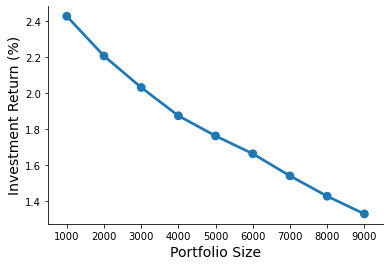

In [ ]:
## Test the best-performing data-driven strategy on different portfolio sizes

test_strategy = 'Default-return-based'
result_sensitivity = []

## Vary the portfolio size from 1,000 to 10,000
for num_loans in list(range(1000,10000,1000)):

    reg_0 = avg_returns_for_hundred_splits(hundred_train_test_splits, 
                                              strategy = test_strategy, 
                                              regressor = reg_separate, 
                                              classifier = your_model,
                                              num_loans = num_loans, 
                                              output_to_file = False)
    result_sensitivity.append(reg_0['ret_PESS'])
    
result_sensitivity = np.array(result_sensitivity) * 100
sns.pointplot(np.array(list(range(1000,10000,1000))),result_sensitivity)
sns.despine()
plt.ylabel('Investment Return (%)',size = 14)
plt.xlabel('Portfolio Size',size = 14)
plt.show()